## Consumer Complaints and Financial Institutions
I use the data provided by [**Consumer Financial Protection Bureau**](http://www.consumerfinance.gov/) to analyze the relationship between the consumers and the financial insitutions (banks, credit companies, ...). This [database](https://catalog.data.gov/dataset/consumer-complaint-database) reports the complaints filed by individuals from 2011 to 2016. 

Questions such as: 
1. average wait time for complaints to be sent to company, 
2. complaints resolution rate for each company
3. companies ranked by the most number of complaints (per capita), 
4. complaints by geographical considerations, i.e. US states
5. word analysis to understand the main issues repoted by the consumers

and many more questions and informative graphs.  

**Requirements:**
- pandas
- matplotlib
- Basemap
- csv
- wordcloud
- numpy
- Image
- path
- random


Let's begin...

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import csv

We tweek the style to have centered plots: 

In [4]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
# This function plots US states and colors them by a given quantity. 
# It uses Basemap packge (https://github.com/matplotlib/basemap/)
# input: 
#    required: 
#       q_states: a python dictionary mapping each state name to a value. e.g. 
#       q_states['California'] = 100
# 
#    optional: 
#       colormapname (see http://matplotlib.org/users/colormaps.html for a more examples)
#       colornorm: identifies the colormap scaling between the values and colors. 
#                   Takes three possible values: 'linear'(default), 'log', 'pow'. 
#                   If power law is set (pow), the exponent gamma can also be set. 
#       plot_title: Title to be used for the figure
# This example was an adaptation from examples listed here: https://github.com/matplotlib/basemap/
def colormap_US(q_states, colormapname='hot', colornorm='linear', gamma=0.5, plot_title='Unknown quantity'):
    from mpl_toolkits.basemap import Basemap as Basemap
    import matplotlib as mpl
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    
    m = Basemap(llcrnrlon=-125,llcrnrlat=20,urcrnrlon=-60,urcrnrlat=50, projection='lcc',lat_1=34.,lat_2=34,lat_0=0,lon_0=-102)
    figure = plt.figure(figsize=(12,8))
    # draw state boundaries.
    # data from U.S Census Bureau
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True)
    # choose a color for each state based on population density.
    cmap = plt.cm.get_cmap(colormapname)

    # set range.
    max_q = max(q_states.itervalues())
    min_q = min(q_states.itervalues())

    vmin = min_q
    vmax = max_q

    # We can have linear, logorithmic or powerlaw to map the colors to the values in the database. 
    if colornorm == 'linear':
    # Linear colormap scaling
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    elif colornorm == 'log':
    # Logarithmic colormap scaling
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax, clip=True)
    elif colornorm == 'pow':
    # Powerlaw colormap scaling
        norm=mpl.colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
    else: 
        print("Warning. Wrong value set for colornorm. Choose 'linear', 'log', or 'pow'. Setting colornorm to 'linear'.")
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
        
    mapper= mpl.cm.ScalarMappable(norm=norm, cmap=colormapname)
    
    # Get all the values given in the dictionary 
    q_values = q_states.values()
    
    statenames=[]
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        statenames.append(statename)

    ax = plt.gca() # get current axes instance
    patches = []
    colorsn = []
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico']: # 'District of Columbia'
            # Offset Alaska and Hawaii to the lower-left corner. 
            if statenames[nshape] == 'Alaska':
                # Alaska is too big. Scale it down to 35% first. 
                seg = list(map(lambda (x,y): (0.35*x + 1100000, 0.35*y-1300000), seg))
            if statenames[nshape] == 'Hawaii':
                seg = list(map(lambda (x,y): (x + 5100000, y-900000), seg))
            # Quantity for the current state
            q_ = q_states[statenames[nshape]]
            # Map the q_value to the rgb color
            color = mapper.to_rgba(q_)

            # Color the polygon for current state based on the color found for q_value
            poly = Polygon(seg,facecolor=color,edgecolor='black')
            patches.append(poly)
            colorsn.append(q_) 
            ax.add_patch(poly)

    plt.title(plot_title)

    # Add all the polygons for all states to the map. 
    p = PatchCollection(patches, cmap=cmap, norm=norm)
    p.set_array(np.array(colorsn))
    cb = figure.colorbar(p, orientation='vertical')    
    plt.show()    

In [6]:
# Mapping the 50 states' names
States = {
        'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas','AZ': 'Arizona', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia','DE': 'Delaware',
        'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho',
        'IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts',
        'MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MS': 'Mississippi',
        'MT': 'Montana','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire',
        'NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
        'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina',
        'SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VT': 'Vermont',
        'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
}

##### Import US populations by states in 2014 and store it in a python dictionary 'Population'
Let us plot it using the above function:

In [7]:
# Import US populations by states in 2014
# Downloaded from: https://www.census.gov/popest/data/state/totals/2014/
Population = {}
with open('Population2014.csv', 'rb') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(csvreader, None)  # skip the header line
    for row in csvreader:
        state_name  = row[0]
        state_population = row[1]
        temp = int(state_population.replace(',',''))
        Population[state_name] = temp

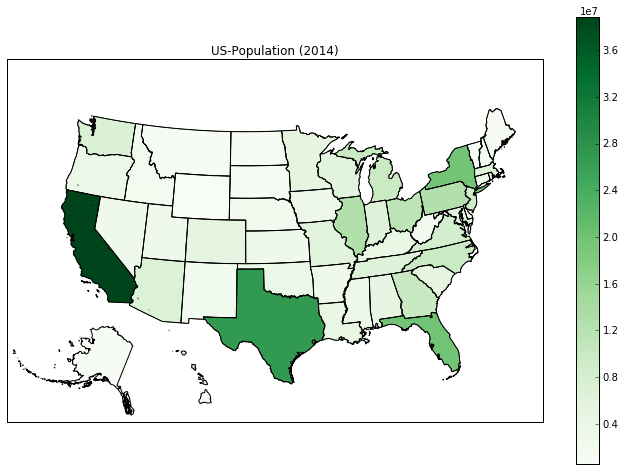

In [8]:
# As a test, let's now color the US map by population
colormap_US(Population, colormapname='Greens', colornorm='linear', gamma=0.5, plot_title="US-Population (2014)")

## 1. Complaints: Wait period

Let's import the entire dataset. This is a very large file: 219 MB of ASCII data. 
You can manually sample a smaller set if you are worried about the memory consumption on your local machine. Pandas package reads the CSV file and identifies the columns automatically. The result is stored in a so-called Data Frame. 

In [9]:
#df = pd.read_csv('Consumer_Complaints.csv', low_memory=False)
df = pd.read_csv('Consumer_Complaints.zip', low_memory=False)

Let's look at the general structure of the dataset. This can be easily investigated by:

In [10]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,07/30/2013,Closed with explanation,Yes,No,468882
1,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889
2,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,07/31/2013,Closed,Yes,No,468879
3,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,468949
4,07/29/2013,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,06106,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,475823


How many complaints are in the dataset? 

In [11]:
Nt = len(df.index)
print('Total number of complaints received: ' + str(Nt))

Total number of complaints received: 631283


We first convert the columns with dates to standard date/time format used in Pandas. **Warning:** This can take a relatively long time. 

In [12]:
df['Date received'] = pd.to_datetime(df['Date received'])
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

**The claims received within 2011 to 2016:**

In [13]:
print('Complaints received between ' + str(df['Date received'].min().date()) + ' and ' + str(df['Date received'].max().date()))

Complaints received between 2011-12-01 and 2016-09-15


Let's now add a new column named 'Wait time' to include the number of days from the time a complaint was received to when it was submitted to each compnay: 

In [14]:
df['Wait time'] = (df['Date sent to company'] - df['Date received']).dt.days
df['Wait time'].describe()

count    631283.000000
mean          4.458245
std          16.695611
min          -1.000000
25%           0.000000
50%           1.000000
75%           4.000000
max         993.000000
Name: Wait time, dtype: float64

There seems to be negative (-1) values in the database. We replace those by 0 (the complaint was sent to the company on the same day):

In [15]:
df['Wait time'].replace(-1, 0, inplace=True)
df['Wait time'].describe()

count    631283.000000
mean          4.469419
std          16.692288
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max         993.000000
Name: Wait time, dtype: float64

**The average wait time is 4.5 days for a complaint to be sent to the relevant bank/institution:**

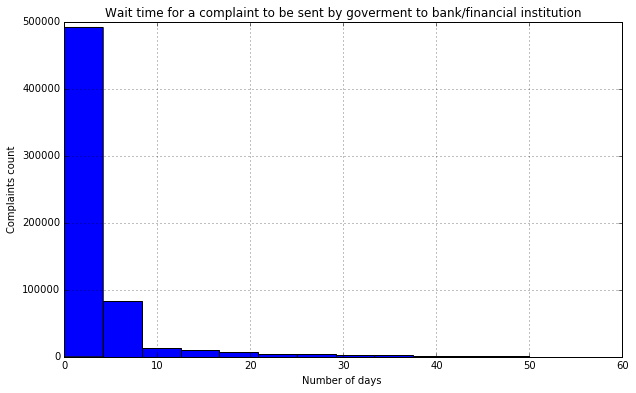

In [16]:
df['Wait time'].hist(bins=12, range=(0,50), figsize=(10,6))#, normed=1)
plt.xlabel('Number of days ')
plt.ylabel('Complaints count')
plt.title('Wait time for a complaint to be sent by goverment to bank/financial institution')

## 2. Consumer complaints: Top 10 institutes with most number of complaints

Let's look at the data and rank the companies based on the consumer complaints count for this period (2012 to 2016) 

In [17]:
# Simply change Nmax to whatever value so you can see more or less of the entire list. 
Nmax = 10
Top10 = df['Company'].value_counts()[0:Nmax]
# Let's add 'Others' to include the rest of the companies. 
Top10['Others'] = Nt - Top10.sum()
print(Top10)

Bank of America                            59691
Wells Fargo & Company                      45627
Equifax                                    38628
JPMorgan Chase & Co.                       37198
Experian                                   36786
TransUnion Intermediate Holdings, Inc.     30841
Citibank                                   29656
Ocwen                                      22369
Capital One                                17213
Nationstar Mortgage                        14444
Others                                    298830
Name: Company, dtype: int64


We now create a data frame based on the top (10) ranked companies based on the number of complaints: 

In [19]:
df_top10 = Top10.to_frame(name='Number of Complaints') # change series to a dataframe 
df_top10['Company'] = df_top10.index
# reset the index column to numerical values (instead of company names)
df_top10 = df_top10.reset_index(drop=True)
# Switch the order of columns (just easier to read)
df_top10 = df_top10[['Company', 'Number of Complaints']]
df_top10

,Company,Number of Complaints
0,Bank of America,59691
1,Wells Fargo & Company,45627
2,Equifax,38628
3,JPMorgan Chase & Co.,37198
4,Experian,36786
5,"TransUnion Intermediate Holdings, Inc.",30841
6,Citibank,29656
7,Ocwen,22369
8,Capital One,17213
9,Nationstar Mortgage,14444


In [ ]:
A pie chart would show this better: 

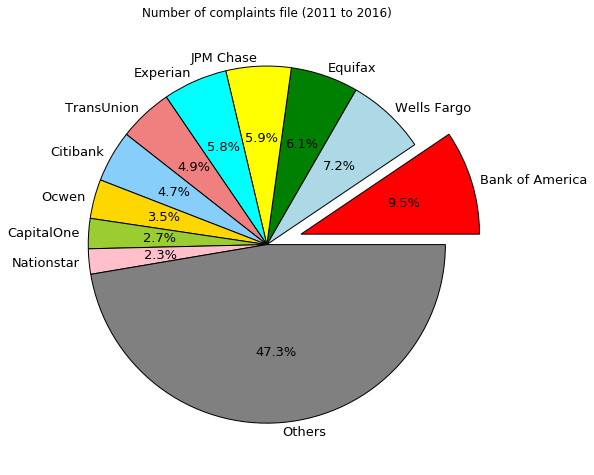

In [20]:
labelnames = ["Bank of America","Wells Fargo","Equifax","JPM Chase","Experian","TransUnion","Citibank","Ocwen","CapitalOne", "Nationstar", "Others"]
mycolors = ['red', 'lightblue', 'green', 'yellow', 'cyan', 'lightcoral', 'lightskyblue', 'gold', 'yellowgreen', 'pink', 'grey']
# First slice corrensponds to Bank of America, one with the most number of complaints. 
myoffsetslice = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
df_top10.plot.pie(figsize=(8,8), subplots=True, legend=None, colors=mycolors, explode=myoffsetslice, autopct='%1.1f%%', labels = labelnames, labeldistance=1.05, fontsize=13)
plt.title('Number of complaints file (2011 to 2016)')
# Turn off the vertical label
plt.gca().get_yaxis().set_visible(False)


## 3. Complaint resolution

We now check how the institutions did with resolving the issues. This function will return the number for any company: 

In [21]:
# Return the number of resolved complaints for a given company. 
def get_company_resolved_count(df, company):
    if (company == 'All'):
        d = df[df['Consumer disputed?'] == 'No']
    else:
        d = df[(df['Company'] == company) & (df['Consumer disputed?'] == 'No')]
    return len(d)

Go through the list of top 10 companies and count the number of non-disputed cases. We count those and add two new columns 'Resolved'. 

In [22]:
N_r = []
N_res_top10 = 0
for company_name in df_top10['Company']:
    if company_name != 'Others':
        N_resolved = get_company_resolved_count(df, company_name)
        N_res_top10 = N_res_top10 + N_resolved
        df_top10.loc[df_top10['Company'] == company_name,'Resolved'] = N_resolved
N_res_tot = len(df[df['Consumer disputed?'] == 'No'])
df_top10.loc[df_top10['Company'] == 'Others','Resolved'] = N_res_tot - N_res_top10
df_top10['Resolved(%)'] = df_top10['Resolved'] / df_top10['Number of Complaints']*100
df_top10

,Company,Number of Complaints,Resolved,Resolved(%)
0,Bank of America,59691,44391.0,74.367995
1,Wells Fargo & Company,45627,33625.0,73.695400
2,Equifax,38628,27391.0,70.909703
3,JPMorgan Chase & Co.,37198,27355.0,73.538900
4,Experian,36786,28743.0,78.135704
5,"TransUnion Intermediate Holdings, Inc.",30841,23288.0,75.509873
6,Citibank,29656,21764.0,73.388185
7,Ocwen,22369,16327.0,72.989405
8,Capital One,17213,13320.0,77.383373
9,Nationstar Mortgage,14444,10535.0,72.936860


Demonstrate the above table in a bar plot: 

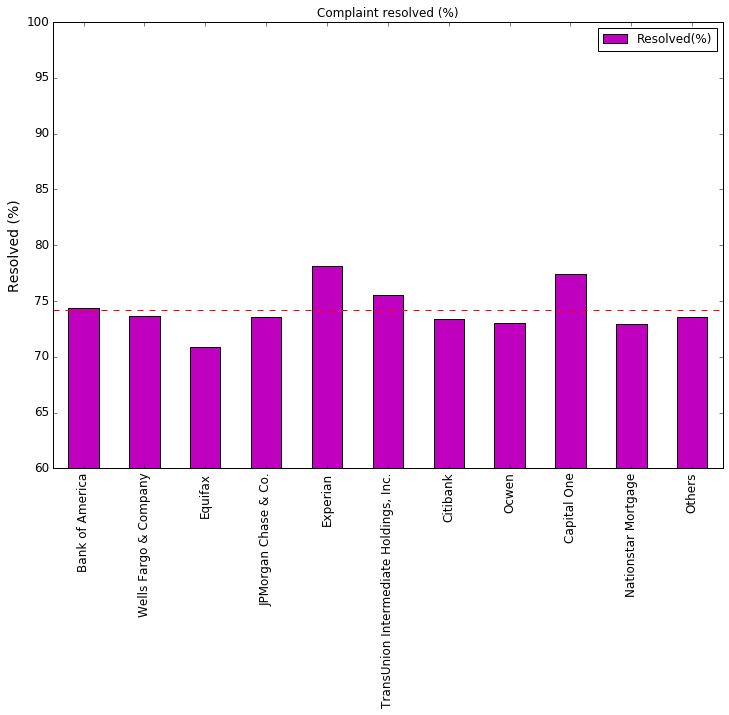

In [23]:
# Extract only the 'Company' name and 'Resolved(%)' columns. 
Slice = df_top10[['Company','Resolved(%)']]
mean_ = float(df_top10['Resolved(%)'].mean())
ax = Slice.plot(x=Slice['Company'], width=0.5, kind='bar', color='m', title ="Complaint resolved (%)",figsize=(12,8),legend=True, fontsize=12)

ax.set_xlabel("",fontsize=16)
ax.set_ylabel("Resolved (%)",fontsize=14)
plt.ylim(60,100)

# Add a horizontal line denoting the average value for Resolved 
xmin,xmax = ax.get_xlim()
plt.plot([xmin,xmax], [mean_, mean_], "r--")
plt.show()

## Observation: 

* **Best** at resolving the issues: **Experian** and **Capital One**

* **Worst** at resolving the issues: ** Equifax** and **Nationstar Mortgage**

## 3. US states and complaint demographics

We now like to investigate whether or not the complaints and the states demonstrate any meaningful correlations. Toward this goal, we count the number of complaints for each company in each US state per capita. 

In [24]:
# This function counts the number of complaints for a given company in a US state. 
# If per_captia flag set to True, the number is divided by the state population (as of 2014)
def get_complaints_count_state_company(df, state, company, per_capita=False):
    global States
    global Population
    if company == 'All':
        d_ = df[df['State'] == state]
    else:
        d_ = df[(df['State'] == state) & (df['Company'] == company)]
    N = float(len(d_))
    if (per_capita):
        N = N/float(Population[States[state]])
    return N

# This function returns the number of complaints for a given company in all 50 US states. 
# If per_captia flag set to True, the number is divided by the state population (as of 2014)
def get_complaints_count_allstates_company(df, company, per_capita=False):
    global States
    comp_count = {}
    # Go through all US states, find the number of complaints for the given company in each US state.
    for state in States.keys():
        nc = get_complaints_count_state_company(df, state, company, per_capita)
        comp_count[state] = nc
    # Replace 2 letter state names by their full names in the dictionary. 
    new_data = {States[name]: val for name, val in comp_count.items()}
    return new_data

In [25]:
def report_complaints_states(d):
    for w in sorted(d, key=d.get, reverse=True):
          print w, d[w]

Here is a map of number of complaints per capita for each state: 

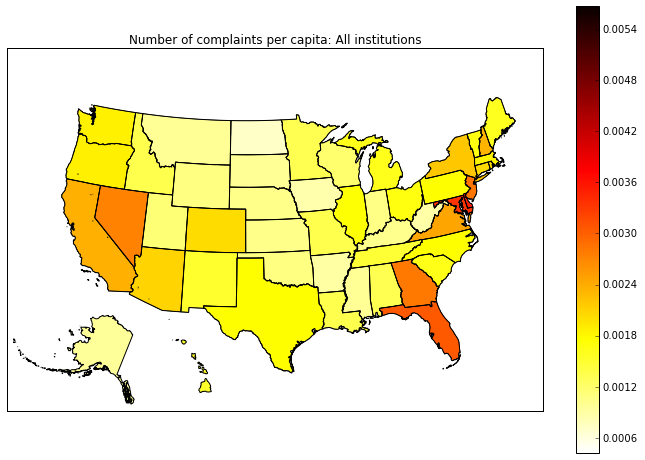

In [26]:
which_company = 'All'
complaint_count_states = get_complaints_count_allstates_company(df, which_company, per_capita=True)
colormap_US(complaint_count_states, colormapname='hot_r', colornorm='linear', plot_title="Number of complaints per capita: All institutions")

** Three 'states' with the most number of complaints (per capita): Delaware, Maryland, and District of Columbia **

Let's now look at 'Bank of America' (ranked first for the most number of complaints): 

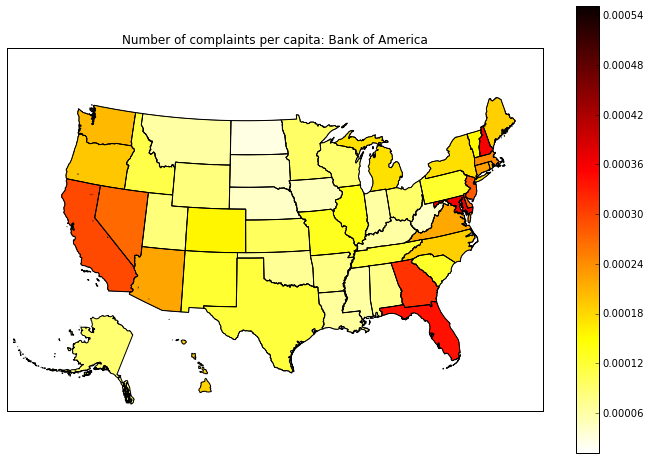

In [27]:
which_company = 'Bank of America'
complaint_count_states = get_complaints_count_allstates_company(df, which_company, per_capita=True)
colormap_US(complaint_count_states, colormapname='hot_r', colornorm='linear', plot_title="Number of complaints per capita: Bank of America")

** Three 'states' with the most number of complaints (per capita): Maryland, District of Columbia, and New Hampshire **

We like to be more precise with our assesment. We now go through all institutions and banks, and find the top three states with the most number of complaints per capita for each company: 

In [28]:
def report_complaints_states(d):
    for w in sorted(d, key=d.get, reverse=True):
          print w, d[w]

In [29]:
# This function sorts states based on the number of complaints per capita and return the top three states. 
def state_with_most_complaints(d):
    newd = dict(sorted(d.iteritems(), key=operator.itemgetter(1), reverse=True)[:3])
    return newd

In [30]:
# Go through all companies and return the three states with most number of complaints per capita.
import operator
df_temp = df_top10
listnames = df_top10['Company'].tolist()
listnames.append('All')
listnames.remove('Others')
for which_company in listnames:
    complaint_count_states = get_complaints_count_allstates_company(df, which_company, per_capita=True)
    top3 = state_with_most_complaints(complaint_count_states)
    print('########### ' + which_company + ' #############')
    for key, value in top3.iteritems():
        print key,': ' ,value
    print('*******************************************' + '\n')

########### Bank of America #############
Maryland :  0.000364767660569
District of Columbia :  0.000550924049884
New Hampshire :  0.000357247027275
*******************************************

########### Wells Fargo & Company #############
New Jersey :  0.000287195092958
District of Columbia :  0.000431025978421
Delaware :  0.000278961195536
*******************************************

########### Equifax #############
Georgia :  0.000219265602842
District of Columbia :  0.000350588031744
Florida :  0.000211830145601
*******************************************

########### JPMorgan Chase & Co. #############
District of Columbia :  0.000288362450352
Florida :  0.000171766399506
New York :  0.000204444119882
*******************************************

########### Experian #############
District of Columbia :  0.000298986330102
Florida :  0.000181166550723
Nevada :  0.000218379140706
*******************************************

########### TransUnion Intermediate Holdings, Inc. #######

### Considering top 10 comapnies with most number of complaints, here are some interesting observations: 

1. **9 out of 10 companies have 'District of Columbia' ranked as top 3 of the 'States' with most number of complaints (per capita).**  
Fun question: Are banks giving the people living in Washington, D.C. a hard time for hosting the politicians? :-)   
2. ** 4 out of 10 companies have 'Florida' ranked top 3 of the states with most number of complaints (per capita).**  
3. ** 4 out of 10 companies have 'Delaware' ranked as top 3 of the 'States' with most number of complaints per capita.**

## 4. Complaint issues: Word clouds

In this section, we like to understand better what the main subjects of the complaints are. To do so, we analyze the 'Issue' column in the dataframe. For each bank or financial institution, we extract every single word for each complaint, and count the most repeated ones. We need to do some cleaning as well. We replace all '.', ',', '  ' by a snigle blank to have an accurate measure on the number of words. For the sake of presentation, we plot the results using word clouds. 

In [31]:
def plot_word_cloud_top_issues(df, company_name):
    if (company_name == 'All'):
        db = df
    else:
        db = df[df['Company'] == company_name]
    db['Issue'].str.replace(',',' ')
    db['Issue'].str.replace('.',' ')
    db['Issue'].str.replace('-',' ')
    db['Issue'].str.replace('  ',' ')
    AllIssues = pd.Series(db['Issue'].str.cat(sep=' '))[0].lower()
    my_word_cloud(AllIssues, n_words=5, plot_title=company_name)        

This function plots a word cloud for a given string. Shows the top n_words most repeated words in a phrase. 
It uses the package wordcloud. For more information: goto [https://github.com/amueller/word_cloud](https://github.com/amueller/word_cloud)

In [32]:
# This function plots a word cloud for a given string. Shows the top n_words most repeated words in a phrase. 
# It uses the package wordcloud. For more info: goto https://github.com/amueller/word_cloud 
def my_word_cloud(text, n_words=5, plot_title=""):
    import numpy as np
    from PIL import Image
    from os import path
    import matplotlib.pyplot as plt
    import random
    from wordcloud import WordCloud, STOPWORDS

    wc = WordCloud(max_words=n_words, margin=25, random_state=0).generate(text)

    # store default colored image
    default_colors = wc.to_array()
    plt.figure(figsize=(8,8))
    plt.title(plot_title)
    plt.imshow(default_colors)
    plt.axis("off")
    plt.show()

Let's start with all financial institutions:

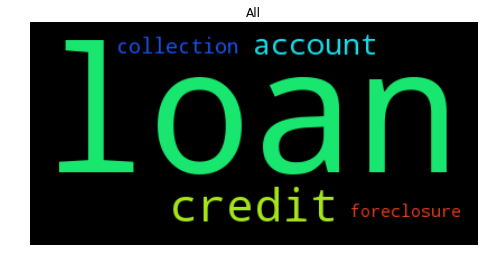

In [33]:
plot_word_cloud_top_issues(df, "All")

**Top three words: Loan, Credit, Account**

Now, 'Bank of America':

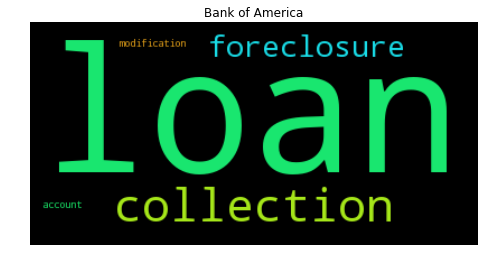

In [34]:
plot_word_cloud_top_issues(df, "Bank of America")

**Top three words in issues (Bank of America): Loan, Collection, foreclosure**

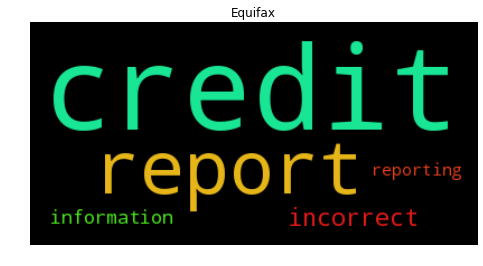

In [35]:
plot_word_cloud_top_issues(df, "Equifax")

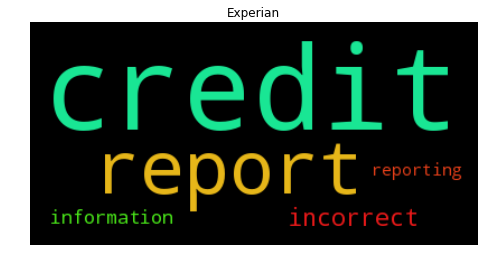

In [36]:
plot_word_cloud_top_issues(df, "Experian")

Equifax (lowest complaint resolution rate) vs Experian (highest complaint resolution rate) have identical issues. 

#### Observations:

1. **Top 5 issues reported by the customers in 2011 to 2016: Loan, Credit, Account, Collection, and Foreclosure**
2. **With almost identical reported complaints, Equifax and Experian had the relatively low and high resolution rates.**